In [34]:
import sys
import os
from pathlib import Path
import importlib

# The notebooks are in a 'notebooks' subfolder, so workspace root is one level up
# This works if notebook is in notebooks/ folder
workspace_root = Path("C:/00_Developement/daily_avg_pv_kpi_heatmap").resolve()

# Add workspace root to path so we can import from src
sys.path.insert(0, str(workspace_root))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src import pvgis_pi_heatmap
importlib.reload(pvgis_pi_heatmap)  # Reload to pick up any changes

from src.pvgis_pi_heatmap import make_random_greece_meta, compute_pi_anomaly, short_label, parse_kwp_from_header

# Store workspace root for use in other cells
WORKSPACE_ROOT = workspace_root


In [16]:
DATA_DIR = WORKSPACE_ROOT / "data"
DATA_XLSX = DATA_DIR / "daily_energy.xlsx"
CACHE_DIR = WORKSPACE_ROOT / "pvgis_cache"

df = pd.read_excel(DATA_XLSX)

# Expect Timestamp column exactly
df["Timestamp"] = pd.to_datetime(df["Timestamp"])
df["date"] = df["Timestamp"].dt.normalize()

park_cols = [c for c in df.columns if c not in ["Timestamp", "date"]]
daily = df.set_index("date")[park_cols].sort_index()

daily.head()


,[4E Energeiaki 176 KWp Likovouni] PCC PCC active energy export (kWh),[4E Energeiaki 4472 KWp Lexaina] PCC PCC active energy export (kWh),[4E Energeiaki 805 KWp Darali] PCC PCC active energy export (kWh),[Fragiatoula_Utilitas_4866kWp] PCC PCC active energy export (kWh),[Hliatoras 474kWp Andravida] PCC PCC active energy export (kWh),"[Ntarali_Bonitas_0,45MW] PCC PCC active energy export (kWh)",[Ntarali_Concept_296KW] PCC PCC active energy export (kWh),[Ntarali_Concept_320KW] PCC PCC active energy export (kWh),[Ntarali_Concept_592KW] PCC PCC active energy export (kWh),[Ntarali_Konenergy_590KW] PCC PCC active energy export (kWh),...,[Solar Concept 276 KWp Likovouni] PCC PCC active energy export (kWh),[Solar Concept 3721 KWp Lexaina] PCC PCC active energy export (kWh),[Solar Datum 2910 KWp Lexaina] PCC PCC active energy export (kWh),[Solar Datum 864 KWp Darali] PCC PCC active energy export (kWh),[Solar Factory 494kWp Andravida] PCC PCC active energy export (kWh),[Spes Solaris 1527 KWp Darali] PCC PCC active energy export (kWh),[Spes Solaris 1986 KWp Lexaina] PCC PCC active energy export (kWh),[Spes Solaris 201 KWp Konizos] PCC PCC active energy export (kWh),[Spes Solaris 500 KWp Kavasila] PCC PCC active energy export (kWh),[Spes Solaris 805 KWp Konizos] PCC PCC active energy export (kWh)
date,,,,,,,,,,,,,,,,,,,,,
2025-01-01,707.263906,13690.78810,3178.12297,19497.56420,1862.90557,1624.783880,NaN,1181.988620,2343.075250,NaN,...,1118.412100,11802.72260,7519.99269,3506.26624,1872.157000,5388.02787,7282.26884,771.653313,1752.171110,3221.45495
2025-01-02,535.072437,12303.91170,2441.87001,16099.87970,1665.58718,1233.700520,NaN,955.627782,1799.238900,NaN,...,831.657080,10555.61630,6713.96331,2695.92049,1676.809360,4171.37447,6536.09108,600.560434,1503.064440,2528.99129
2025-01-03,715.491591,8690.20766,3158.18414,11886.49750,1200.96122,1625.586510,NaN,1227.271100,2324.039020,NaN,...,1127.917000,6535.99875,4720.39404,3492.12314,1216.047450,5339.43444,4605.84629,765.395146,1127.577790,3192.74539
2025-01-04,274.682227,4652.46671,1205.84061,5857.67208,641.19915,626.812243,NaN,448.490281,901.944051,NaN,...,435.395871,3255.48212,2614.41776,1323.15072,661.702906,1908.72506,2530.47494,298.126989,613.654995,1245.83766
2025-01-05,617.347141,11928.90140,3070.94270,19818.53920,1796.94311,1547.586170,NaN,1199.117510,2262.057810,NaN,...,987.905573,11271.91760,3857.56946,3354.53064,1697.702930,5026.97647,6796.93482,706.645516,1767.604440,3000.81426


In [19]:
# ASSUMPTIONS:
# - random lat/lon inside Greece bounding box
# - loss_pct = 18% for older parks
# - timezone = Europe/Athens
meta = make_random_greece_meta(
    park_columns=park_cols,
    seed=7,
    loss_pct=18.0,
    timezone="Europe/Athens"
)

meta.head()


,park_label,kwp,latitude,longitude,loss_pct,timezone,tilt_deg,azimuth_deg
column_header,,,,,,,,
[4E Energeiaki 176 KWp Likovouni] PCC PCC active energy export (kWh),4E Energeiaki 176 KWp Likovouni,176.0,39.175668,24.696618,18.0,Europe/Athens,NaN,NaN
[4E Energeiaki 4472 KWp Lexaina] PCC PCC active energy export (kWh),4E Energeiaki 4472 KWp Lexaina,4472.0,41.080497,19.408661,18.0,Europe/Athens,NaN,NaN
[4E Energeiaki 805 KWp Darali] PCC PCC active energy export (kWh),4E Energeiaki 805 KWp Darali,805.0,40.229800,19.331827,18.0,Europe/Athens,NaN,NaN
[Fragiatoula_Utilitas_4866kWp] PCC PCC active energy export (kWh),Fragiatoula_Utilitas_4866kWp,4866.0,36.376450,23.788466,18.0,Europe/Athens,NaN,NaN
[Hliatoras 474kWp Andravida] PCC PCC active energy export (kWh),Hliatoras 474kWp Andravida,474.0,36.901164,23.335716,18.0,Europe/Athens,NaN,NaN


In [23]:
# Debug: Check date range that will be used
print(f"Date range in data: {daily.index.min()} to {daily.index.max()}")
print(f"Data years: {daily.index.min().year} to {daily.index.max().year}")

Date range in data: 2025-01-01 00:00:00 to 2026-01-12 00:00:00
Data years: 2025 to 2026


In [35]:
pi, score, flag = compute_pi_anomaly(
    daily_df=daily,
    meta=meta,
    cache_dir=CACHE_DIR,
    pvgis_url="https://re.jrc.ec.europa.eu/api/",  # can pin PVGIS version if desired :contentReference[oaicite:11]{index=11}
)

pi.tail(), score.tail(), flag.tail()


PVGIS per park:   5%|▍         | 1/22 [00:00<00:06,  3.06it/s]

PVGIS per park:  18%|█▊        | 4/22 [00:04<00:19,  1.07s/it]

PVGIS per park:  50%|█████     | 11/22 [00:14<00:12,  1.17s/it]

PVGIS per park:  55%|█████▍    | 12/22 [00:14<00:09,  1.10it/s]

PVGIS per park:  73%|███████▎  | 16/22 [00:19<00:06,  1.04s/it]

PVGIS per park:  95%|█████████▌| 21/22 [00:26<00:01,  1.16s/it]

PVGIS per park: 100%|██████████| 22/22 [00:28<00:00,  1.29s/it]


(            [4E Energeiaki 176 KWp Likovouni] PCC PCC active energy export (kWh)  \
 date                                                                               
 2026-01-08                                                NaN                      
 2026-01-09                                                NaN                      
 2026-01-10                                                NaN                      
 2026-01-11                                                NaN                      
 2026-01-12                                                NaN                      
 
             [4E Energeiaki 4472 KWp Lexaina] PCC PCC active energy export (kWh)  \
 date                                                                              
 2026-01-08                                                NaN                     
 2026-01-09                                                NaN                     
 2026-01-10                                                NaN     

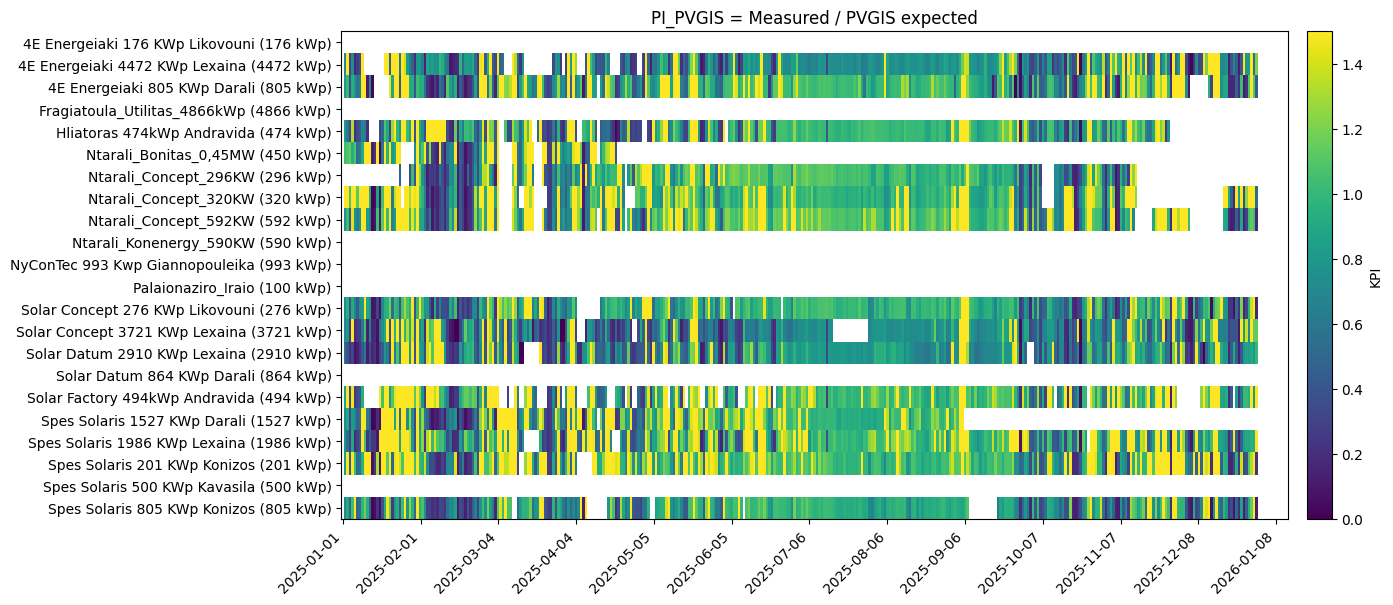

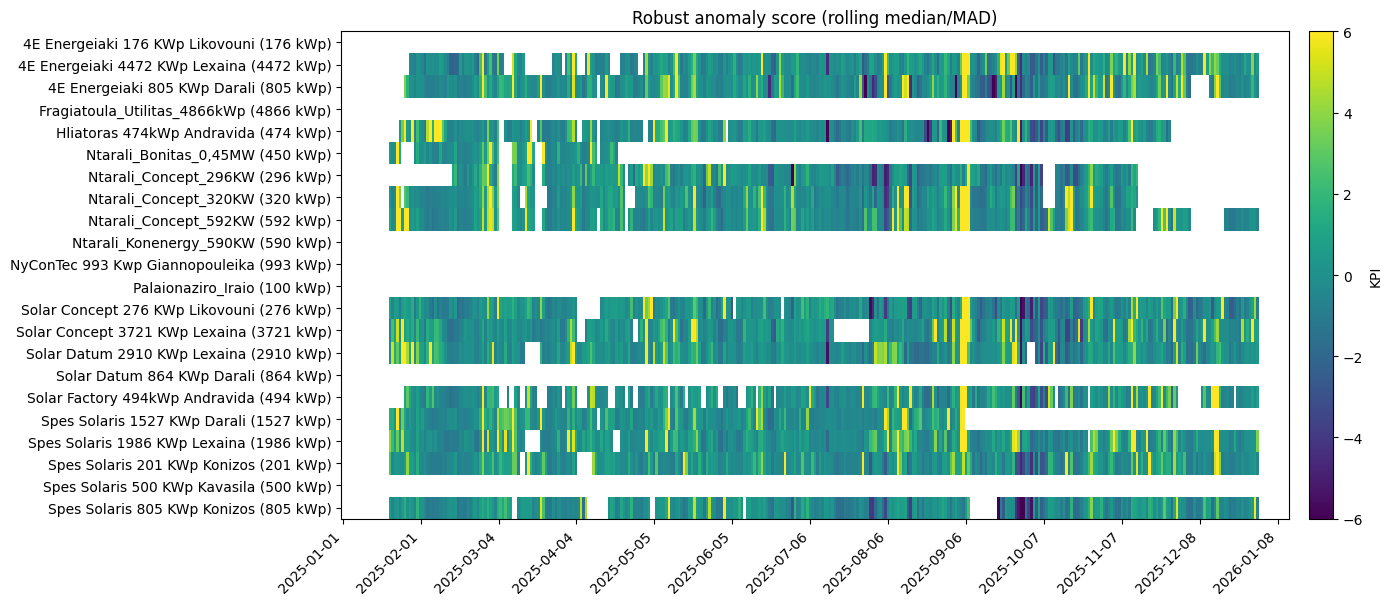

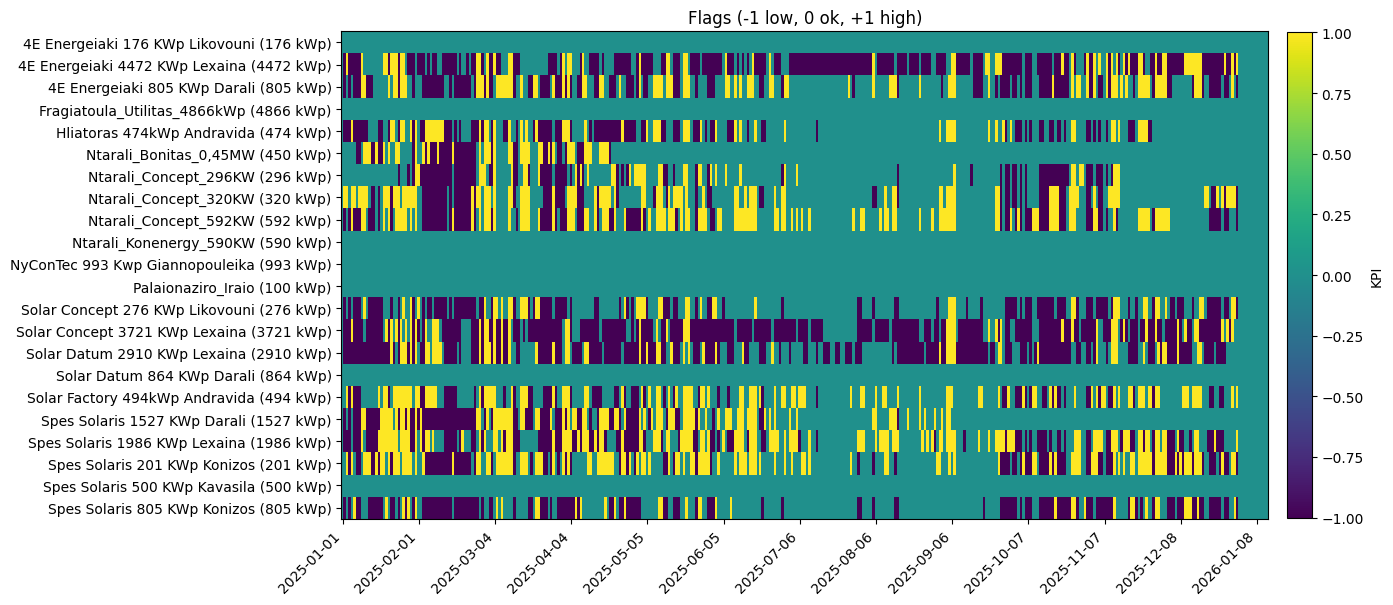

In [36]:
def plot_heatmap(mat: pd.DataFrame, title: str, vmin=None, vmax=None):
    # mat: date x park -> we plot parks x dates
    m = mat.T.copy()

    # nicer y labels (park label + kWp)
    y = []
    for col in m.index:
        y.append(f"{short_label(col)} ({parse_kwp_from_header(col):.0f} kWp)")
    m.index = y

    fig, ax = plt.subplots(figsize=(14, max(6, 0.28 * len(m.index))))
    im = ax.imshow(m.values, aspect="auto", interpolation="nearest", vmin=vmin, vmax=vmax)

    ax.set_title(title)
    ax.set_yticks(np.arange(len(m.index)))
    ax.set_yticklabels(m.index)

    dates = pd.to_datetime(m.columns)
    step = max(1, len(dates) // 12)
    xticks = np.arange(0, len(dates), step)
    ax.set_xticks(xticks)
    ax.set_xticklabels([d.strftime("%Y-%m-%d") for d in dates[::step]], rotation=45, ha="right")

    cbar = plt.colorbar(im, ax=ax, fraction=0.025, pad=0.02)
    cbar.ax.set_ylabel("KPI", rotation=90)
    plt.tight_layout()
    plt.show()

plot_heatmap(pi, "PI_PVGIS = Measured / PVGIS expected", vmin=0.0, vmax=1.5)
plot_heatmap(score, "Robust anomaly score (rolling median/MAD)", vmin=-6, vmax=6)
plot_heatmap(flag, "Flags (-1 low, 0 ok, +1 high)", vmin=-1, vmax=1)

